In [1]:
col_names = [
    'dv', 
    'fv',
    'dv-fv'
]

In [2]:
import configparser
import warnings
from pymongo import MongoClient

warnings.filterwarnings("ignore", category=DeprecationWarning)

config = configparser.ConfigParser()
config.read('config.ini')
host = config['DEFAULT']['IP']
port = config['DEFAULT']['MongoDB-Port']

client = MongoClient(host, int(port))
db = client['Media-cloud']

# Venn Diagram

In [3]:
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
# Get counts of each collection 

count_fv = db['fv'].find({}).count()
count_dv = db['dv'].find({}).count()
count_fv_dv = db['dv-fv'].find({}).count()

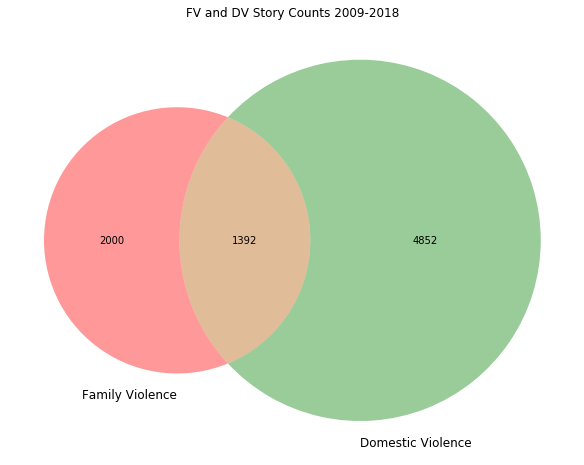

In [6]:
plt.figure(figsize=(12,8))
plt.title('FV and DV Story Counts 2009-2018')
venn2(subsets = (count_fv, count_dv, count_fv_dv), set_labels = ('Family Violence', 'Domestic Violence'))
plt.show()

# Top Words

In [17]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Stop words
stop = set(stopwords.words('english'))
# stop.update([
#     'say',
#     'would',
#     'year',
#     'one',
#     'go',
#     'get',
#     'take',
#     'also',
#     'need',
#     'want',
#     'make',
#     'family',
#     'domestic',
#     'mr',
#     'people',
#     'give',
#     'could',
#     'day',
#     'week'
# ])

# Lemmatizer
lmtz = WordNetLemmatizer()

In [6]:
# Lemmatize words to their base form

def lemmatize(token):
    lemma = lmtz.lemmatize(token, 'v')
    if lemma == token:
        lemma = lmtz.lemmatize(token, 'n')
    return lemma

In [ ]:
freqs = {}                           # Word frequency
for col_name in col_names:
    col = db[col_name]
    counter = 0                      # Count processed stories and display
    
    for story in col.find({}):
        if story['text'] != None:
            text = story['text']
            
            for token in word_tokenize(text):
                if token.isalpha():
                    lemma = lemmatize(token.lower())               # Lemmatize word and update its frequency
                    if lemma not in stop:
                        freqs[lemma] = freqs.get(lemma, 0) + 1
                        
        counter += 1
        if counter % 1000 == 0:
            print(counter,'precessed')

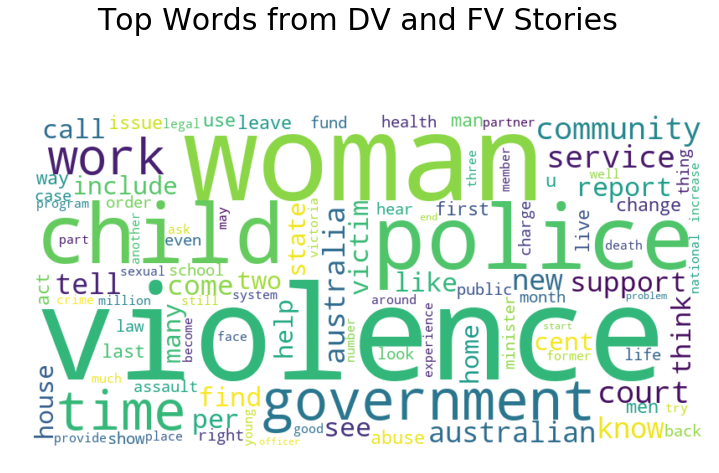

In [8]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white")
wordcloud.generate_from_frequencies(frequencies=freqs)

plt.figure(figsize=(12,8)).suptitle('Top Words from DV and FV Stories', fontsize=30)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

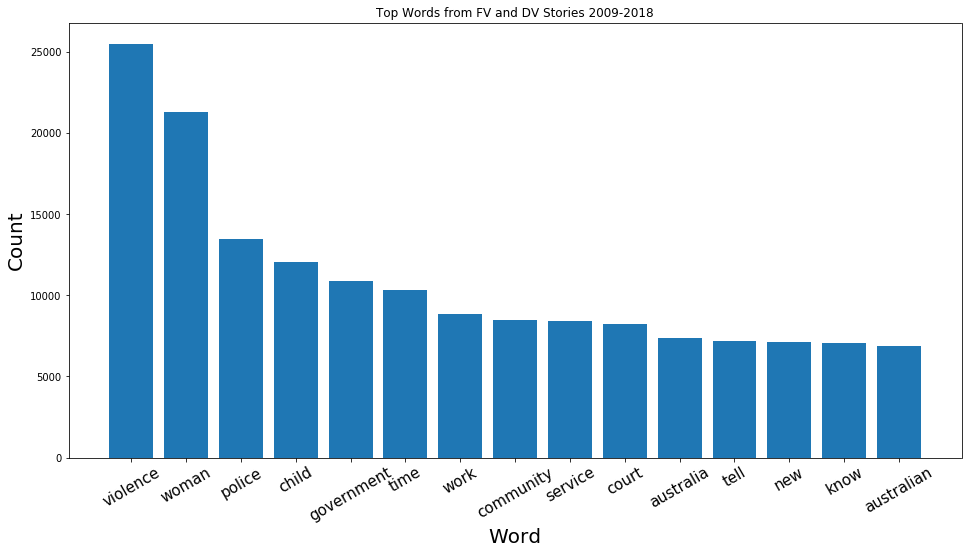

In [16]:
# Bar chart

import numpy as np

x = []          # X axis - top words
y = []          # Y axis - word counts
count = 0       # Numer of top words to show

for word in sorted(freqs, key=freqs.get, reverse=True):
    x.append(word)
    y.append(freqs[word])
    count += 1
    if count == 15:
        break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Word', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(index, x, fontsize=15, rotation=30)
plt.title('Top Words from FV and DV Stories 2009-2018')
plt.show()

### Analysis

The words that appear (word counts) the most in all the DV and FV stories, excluding stop words and generic words (e.g. 'like', 'go').

- Except for 'Violence' which is the search term, 'Women' appears much more times than any other word. This tells a sad truth that the majority of FV and DV victims are women.
- Yet 'Police' is only half as present as 'Violence' in the stories, which indicates that many of the violent acts were not reported to the police in time; and since this is the case for the bigger stories which can make the news, it is more so for all the other not-on-the-media cases, which makes up the majority of FV and DV. Many victims do not report to the police or tell others because they are afraid or kind, but this will only lead to more violence and harm from the offenders.
- 'Child' appears many times as well, because all the FV and DV will have a significant negative impact on the growth of the children in the family, especially on their mental health, which may in turn caue the children to become violent in the family, making it a vicious circle.
- 'Government' - Government policies is a major topic in DV elimination. Many call for the government to put in more effort into legislation and law enforcement to stop the crimes.
- 'Time' - It has been increasingly campaigned in recent years that it is hight time we all made changes to fight DV, with movements including 'TimesUp', 'MeToo' etc., instead of fearing, enduring or tolerating as many victims did in the past. This fact also reflects on the power and influence of social media. Now every movement and campaign ideas can spread to any corner of the world in a matter of minutes, and more and more victims are stepping up to tell their stories and encourage everyone to stand together and fight DV, and giving strengths to those in need, which effectively creates a virtuous circle.
- 'Work', 'Community' - Everyone in the community needs to work together to help eliminate DV.
- 'Court' - Offenders should be brought to court but 'Court' does not appear as much as 'Violence', which also suggests that offences may not be sufficiently reported and punished, and that changes are needed to improve the situation.
- 'Tell' - Victims are encouraged tell the offences to the police and/or their family friends for support.
- 'New' - It is believed that, with the advancement of technology and communication, this is a new era for fighting DV, and everyone should make new changes to make it happen.
- 'Know' - FV crimes should be known to the police (and/or others) so that criminals can be brought to justice and victims can be supported.

# Bi-Gram

In [ ]:
# Bi-gram

from nltk import sent_tokenize

bigram_counts = {}                   # Stores count of bigrams, eg bigram_counts[('i','like')] = 12345

for col_name in col_names:
    col = db[col_name]
    counter = 0                      # Track process
    
    for story in col.find({}, no_cursor_timeout=True):
        for sent in sent_tokenize(story['text']):              # Sentences
            
            tokens = []                                        # Store cleaned word tokens
            for token in word_tokenize(sent):
                if token.isalpha():
                    lemma = lemmatize(token.lower())               # Lemmatize
                    if lemma not in stop:
                        tokens.append(lemma)
                        
            for i, token in enumerate(tokens):
                if i == len(tokens) - 1:
                    break
                bigram_counts[(token, tokens[i+1])] = bigram_counts.get((token, tokens[i+1]), 0) + 1
                
        counter += 1
        if counter % 100 == 0:
            print(counter,'processed')

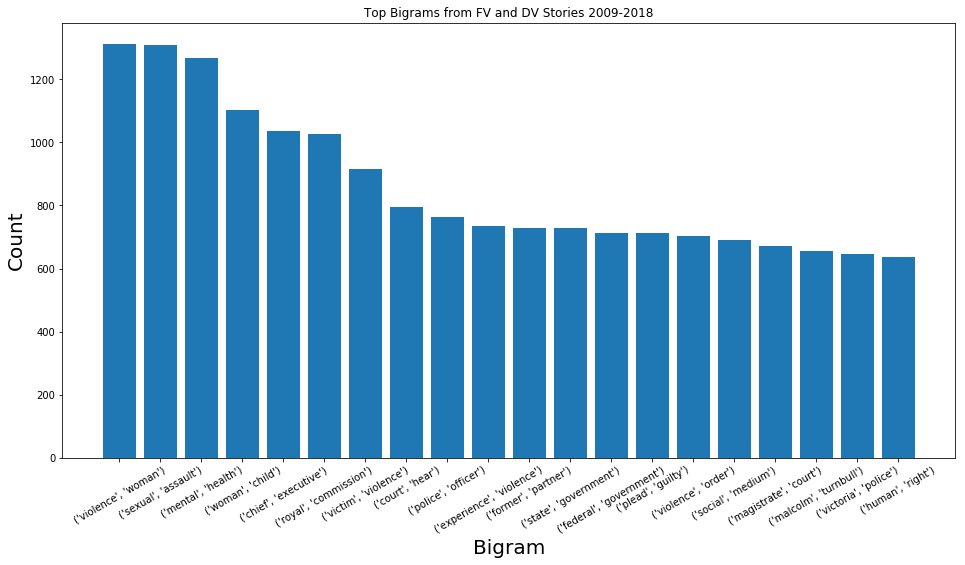

In [11]:
# Top bigrams

x = []          # X axis - bigrams
y = []          # Y axis - counts
count = 0       # Numer of top entities to show

for pair in sorted(bigram_counts, key=bigram_counts.get, reverse=True):
    
    # Remove bias values
    if pair not in [('per', 'cent'), ('fairfax','medium'), ('prime','minister')]:                          
        x.append(pair)
        y.append(bigram_counts[pair])
        count += 1
        if count == 20:                                                        # Limit the num of bigrams to show
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Bigram', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Bigrams from FV and DV Stories 2009-2018')
plt.show()

### Analysis

The Bi-gram chart shows the most frequent 2-word sequences (word pair count).

- violence, women - this indicates that the mojarity of the FV and DV is commited towards women.
- mental, health - this reveals the connection between mental health and DV. DV is a major contributor to children's mental health issues, and as dicussed above, mental health issues in turn contribute to becoming violent. 
- chief, executive - many chief executives of organisations related to DV are mentioned or interviewed in the news stories. Some of them expressed concerns for new types or opportunities for DV and sex crimes brought about by the new online services and apps popular among young people. 
- royal,commission - royal commissions are the symbol of the Crown's concern and effort on solving DV problems. People also hope the commission can facilitate the changes that need to take place from the government and the public. Unfortunately, in Victoria, the Royal Commission into Family Violence ended in 2016; on contrast, Mental Health Royal Commission is still active.
- experience,violence - this indicates that many people have experienced violence in the past, but not all of them reported the violence, and some of the violent criminals escaped punishment.
- former,partner - this indicates that many couples separated after violent incidents, which is a positive sign.

# Top Themes

In [ ]:
# Compute frequency for each theme from the database

freq = {}
for col_name in col_names:
    col = db[col_name]
    counter = 0
    
    for story in col.find({}):
        s = story['themes']
        if s != None:
            for split in s.split(','):
                theme = split.strip()
                freq[theme] = freq.get(theme, 0) + 1
                
        counter += 1
        if counter % 500 == 0:
            print(counter, 'processed')

In [14]:
total = 0                         # Total number of theme counts
for _, count in freq.items():
    total += count

labels = []                       # Labels of pie chart
sizes = []                        # Count of each theme
n = 0                             # Number of themes to display separately in pie chart (others will be grouped)
total_top = 0                     # Total number of seperately displayed themes

for theme in sorted(freq, key=freq.get, reverse=True):
    if theme == 'domestic violence':
        continue
    labels.append(theme)
    theme_freq = freq[theme]
    sizes.append(theme_freq)
    total_top += theme_freq
    n += 1
    if n == 15:                   # Limit the number of separately displayed themes
        break
    
labels.append('others')           # Add the others category
sizes.append(total-total_top)     # and its count

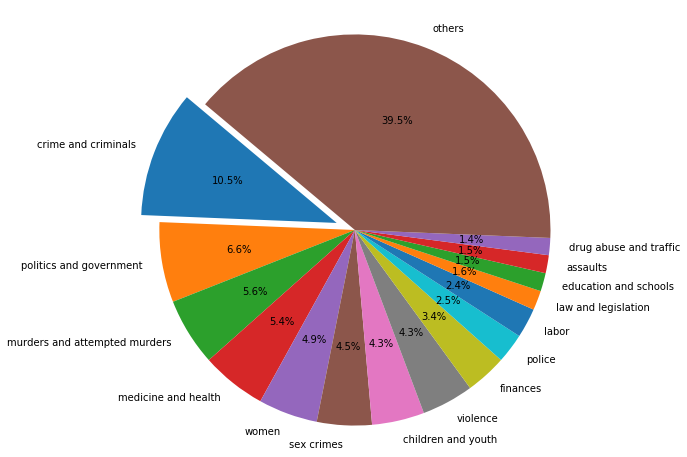

In [15]:
plt.figure(figsize=(8,8))
explode = (0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)                       # Emphasize the first theme
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode)  # Display in percentage
 
plt.axis('equal')
plt.show()

### Analysis

The pie chart shows the percentage of the most frequent themes compared to the total number of theme appearances.

- At the top, far ahead of others, is 'Crime and criminals'. This is becasue FV and DV are crimes and all the reported cases should be related to crime and criminals.
- Murders and attempted murders - unfortunately, many of the FV cases involved (attempted) murders, but that is also the reason the case would make news.
- Sex crimes - many FV cases actually involves sex crimes. Many people would forget that sexual abuse in the family is also intolerable and an act of family violence and domestic violence.

# Top Entities (Person, Orgnisation, Location)

In [60]:
# Named entity recognition - Spacy library
# Need to run "python -m spacy download en" & "python -m spacy download en_core_web_sm"

import spacy

nlp = spacy.load('en_core_web_sm')          # English language

In [ ]:
person_freqs = {}                    # Named persons - how many percent of stories mentioned them
org_freqs = {}                       # Organisations
loc_freqs = {}                       # Locations

for col_name in col_names:
    col = db[col_name]
    counter = 0                      # Count processed stories and track
    
    for story in col.find({}, no_cursor_timeout=True):
        if story['text'] != None:
            text = story['text']
            
            counted_ents = set()                                      # Count entities only once for each story
            for ent in nlp(text).ents:                                # Spacy named entities
                name = ent.text
                
                if name not in counted_ents:
                    counted_ents.add(name)
                    
                    if ent.label_ == 'PERSON':
                        person_freqs[name] = person_freqs.get(name, 0) + 1
                    if ent.label_ == 'ORG':
                        org_freqs[name] = org_freqs.get(name, 0) + 1
                    if ent.label_ == 'GPE':                                          # Countries/states/...
                        loc_freqs[name] = loc_freqs.get(name, 0) + 1
                    
        counter += 1
        if counter % 100 == 0:
            print(counter, 'processed')

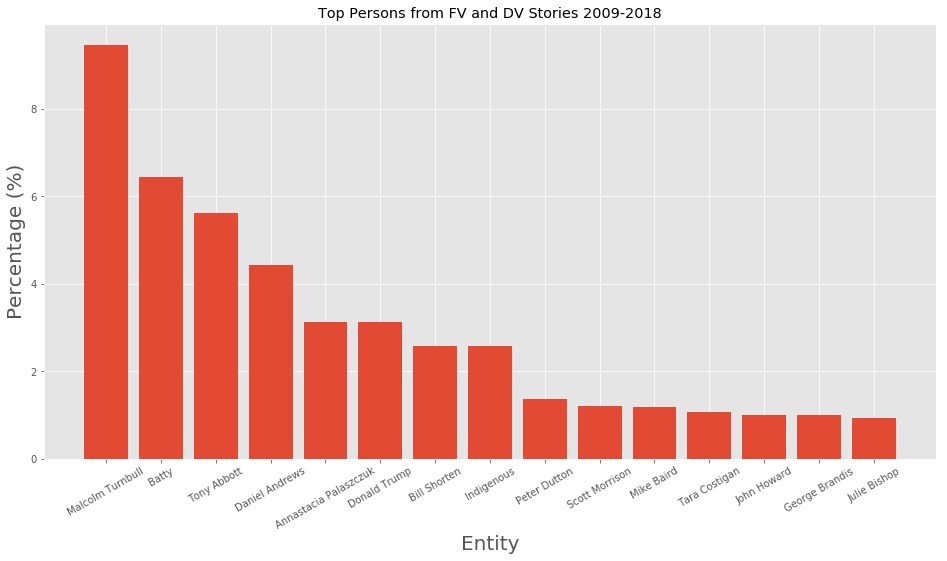

In [113]:
# We combine all the stories under Luke Batty, Rosie Batty and Batty into Batty bucket

# Top persons

freqs = person_freqs

# Adjust for same entities
freqs['Malcolm Turnbull'] += freqs['Turnbull']
freqs['Turnbull'] = 0
freqs['Tony Abbott'] += freqs['Abbott']
freqs['Abbott'] = 0
freqs['Daniel Andrews'] += freqs['Andrews']
freqs['Andrews'] = 0
freqs['Annastacia Palaszczuk'] += freqs['Palaszczuk']
freqs['Palaszczuk'] = 0
freqs['Batty'] += freqs['Rosie Batty'] + freqs['Luke']
freqs['Luke'] = 0
freqs['Rosie Batty'] = 0
freqs['Donald Trump'] += freqs['Trump']
freqs['Trump'] = 0
 
x = []          # X axis - entities
y = []          # Y axis - percentage of stories with the entity
count = 0       # Numer of top entities to show

for ent in sorted(freqs, key=freqs.get, reverse=True):
    
    # Error values
    if ent.strip() not in ['', 'Victoria', 'Victoria Police', 'Mum','Bill','Darwin']:                          
        x.append(ent)
        total = count_dv+count_fv+count_fv_dv                                  # Total num of stories
        y.append(freqs[ent]/total*100)                                         # Percentage
        count += 1
        if count == 15:                                                        # Limit the num of entities to show
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Entity', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Persons from FV and DV Stories 2009-2018')
plt.show()

### Analysis

The percentage of stories where the named entities appear (most frequent).

- Malcolm Turnbull - Australians are constantly concerned with the government policies related to FV. The changes or introduction of laws and regulations from the Turnbull government and state governments as well as politician opinions are frequently discussed in the news articles. That is reason why most of the names in the top list are politicians, such as Tony Abbott, Daniel Andrews.
- Batty - this is one of the best known case in Australia. Luke Batty was murder by his father at the age of 11, and her mother Rosie Batty later became a DV campaigner and also the 2015 Australian of the Year. The tragedy made more people aware of the seriousness of DV and has since been frequently referenced.
- Donald Trump - Although a foreign politician, he is mentioned in many stories. This is mainly due to his negative reputation. His policies, characters and image are frequently referenced as a negative example of problems in the current world.
- Indigenous - FV and DV also occurs the community of indigenoud Australians. It is a national issue that everyone need to take seriously and make contribution to.

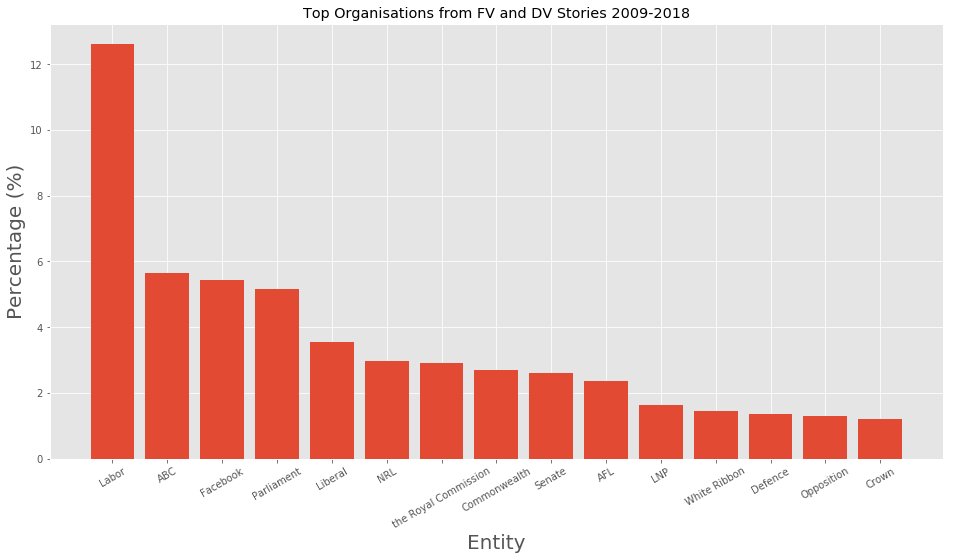

In [114]:
# Top orgs

freqs = org_freqs

# Adjust for same entities
freqs['Labor'] += freqs['ALP'] + freqs['the Labor Party']
freqs['ALP'] = 0
freqs['the Labor Party'] = 0

freqs['Liberal'] += freqs['the Liberal Party']
freqs['the Liberal Party'] = 0

x = []          # X axis - entities
y = []          # Y axis - percentage of stories with the entity
count = 0       # Numer of top entities to show

for ent in sorted(freqs, key=freqs.get, reverse=True):
    
    # Error values
    if ent.strip() not in ['',
                           'NSW',
                           'ACT',
                           'Fairfax Media',
                           'Brisbane',
                           'Family Violence',
                           'Western Australia',
                           'CCTV',
                           'The Canberra Times',
                           'Media',
                           'CBD',
                           'WA',
                           'State'
                          ]:                          
        x.append(ent)
        total = count_dv+count_fv+count_fv_dv                                  # Total num of stories
        y.append(freqs[ent]/total*100)                                         # Percentage
        count += 1
        if count == 15:
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Entity', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Organisations from FV and DV Stories 2009-2018')
plt.show()

### Analysis


- Luke Batty Foundation Facebook page
- A group for sex abuse victims posted on Facebook protesting a doctor who 'cured' gay
- Corrections Victoria online vote for audience questions
- VicPol research posted on FB, where some blamed single mums for sons' DV
- Goldfields Police Service Area Eyewatch Facebook page


- Family violence victims most common prey of predatory Victorian police. Victims share statuses on Facebook, and the officers contact and comfort them via Facebook as well.
- Facebook and other location tracking services become weapons of abuse
- It now seems that people of all ages are more likely to identify with a 'community' that's been defined by their Facebook page than by the township or neighbourhood.
- Facebook adding measures to report 'revenge-porn'
- Woman posts intimate images of husband with mistress


- George Tannous not guilty by reason of mental illness for murder of wife Margaret Tannous. Son posted tribute to her on FB.


- Facebook post reveals anti samesex-marriage poster in water bills
- Bio parents learn about their daughter's death in foster home only via Facebook
- Past Facebook posts from a terrorist revealed his tendencies
- Wanted man who posted pictures of himself on Facebook mocking police was arrested
- Suicide note on Facebook just before a man committed it
- Burke St Mall driver's Facebook posts revealed
- On Facebook, Brad was labelled a manipulator, controlling and dangerous. This was emotional abuse yet his ex-wife said yes again to his proposal.
- Alleged offender's Facebook page shows a violent man with a hatred for police

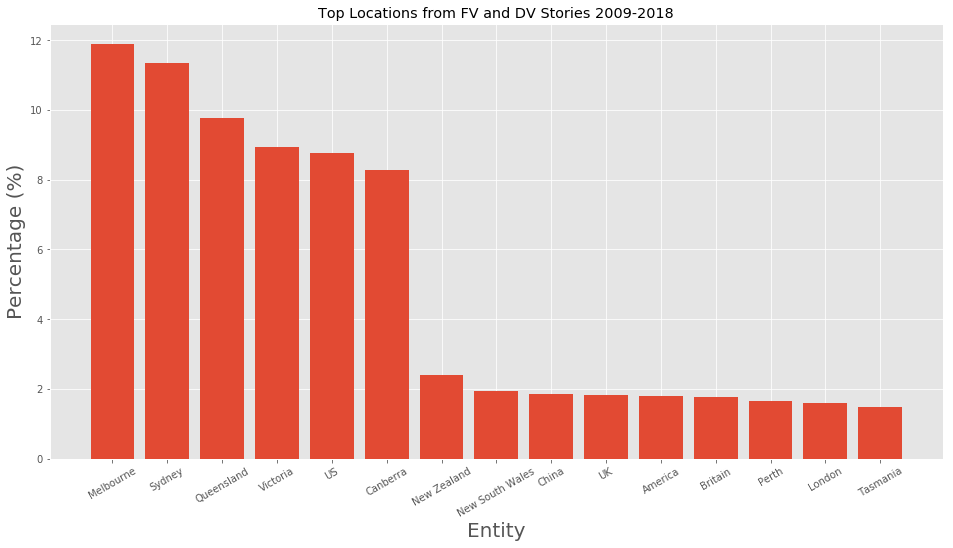

In [116]:
# Top locations

freqs = loc_freqs

freqs['US'] += freqs['the United States']
freqs['the United States'] = 0

x = []          # X axis - entities
y = []          # Y axis - percentage of stories with the entity
count = 0       # Numer of top entities to show

for ent in sorted(freqs, key=freqs.get, reverse=True):
    
    # Error values
    if ent.strip() not in ['',
                           'Fairfax',
                           'Twitter',
                           'Australia'
                          ]:                          
        x.append(ent)
        total = count_dv+count_fv+count_fv_dv                                  # Total num of stories
        y.append(freqs[ent]/total*100)                                         # Percentage
        count += 1
        if count == 15:
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Entity', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Locations from FV and DV Stories 2009-2018')
plt.show()

# Facebook 3-grams

In [ ]:
trigram_counts = {}

counter = 0 
for col_name in col_names:
    col = db[col_name]
    
    for story in col.find({"$text": {"$search": 'facebook'}}, no_cursor_timeout=True):
        for sent in sent_tokenize(story['text']):              # Sentences
            
            tokens = []                                        # Store cleaned word tokens
            for token in word_tokenize(sent):
                if token.isalpha():
                    lemma = lemmatize(token.lower())               # Lemmatize
                    if lemma not in stop:
                        tokens.append(lemma)
                        
            for i, token in enumerate(tokens):
                if i >= len(tokens) - 2:
                    break
                trigram_counts[(token, tokens[i+1], tokens[i+2])] = trigram_counts.get((token, tokens[i+1], tokens[i+2]), 0) + 1
                
        counter += 1
        if counter % 50 == 0:
            print(counter,'processed')

('post', 'facebook', 'page') 8
('news', 'via', 'facebook') 8
('twitter', 'facebook', 'linkedin') 5
('facebook', 'page', 'mr') 5
('write', 'facebook', 'post') 5
('comment', 'facebook', 'page') 4
('organisation', 'facebook', 'page') 4
('private', 'facebook', 'group') 4
('statement', 'facebook', 'page') 4
('like', 'facebook', 'twitter') 4


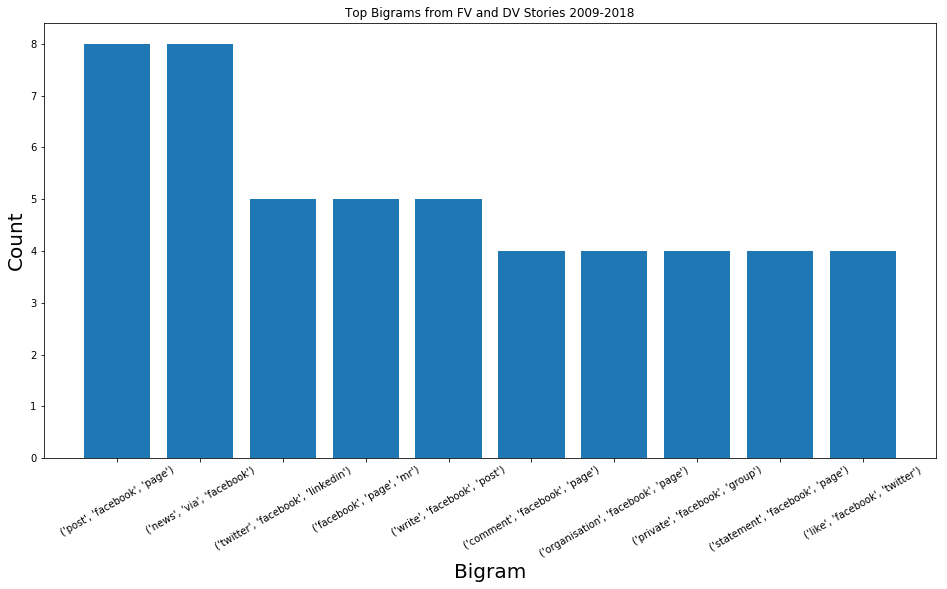

In [29]:
x = []      
y = []      
count = 0   

for trio in sorted(trigram_counts, key=trigram_counts.get, reverse=True):
    
    if 'facebook' in trio and trio not in [
        ('brisbane', 'time', 'facebook'),
        ('follow', 'facebook', 'fee'),
        ('time', 'facebook', 'page'),
        ('sure', 'follow', 'facebook'),
        ('like', 'u', 'facebook'),
        ('mysmallbusiness', 'twitter', 'facebook'),
        ('change', 'facebook', 'profile'),
        ('follow', 'perkinsmiki', 'facebook'),
        ('jam', 'massola', 'facebook'),
        ('facebook', 'profile', 'picture')
    ]:                          
        x.append(trio)
        y.append(trigram_counts[trio])
        print(x[-1], y[-1])
        
        count += 1
        if count == 10:
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Bigram', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Bigrams from FV and DV Stories 2009-2018')
plt.show()